In [16]:
import os
os.chdir("C:\projects\Dr_Detection")

In [17]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [18]:
from  Dr_detection.constants import *
from Dr_detection.utils import read_yaml, create_directories
import tensorflow as tf

In [19]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "train")
        create_directories([
            Path(training.root_dir)  
            ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [20]:
import time
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True
        )

    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [21]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

In [22]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()
    
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )
    
except Exception as e:
    raise e

[2024-03-03 12:55:33,669: INFO: common]: yaml file: configs\config.yaml loaded successfully


[2024-03-03 12:55:33,794: INFO: common]: yaml file: params.yaml loaded successfully
[2024-03-03 12:55:33,873: INFO: common]: created directory at: artifacts
[2024-03-03 12:55:33,882: INFO: common]: created directory at: artifacts\prepare_callbacks\checkpoint_dir
[2024-03-03 12:55:33,885: INFO: common]: created directory at: artifacts\prepare_callbacks\tensorboard_log_dir
[2024-03-03 12:55:34,305: INFO: common]: created directory at: artifacts\training
Found 550 images belonging to 5 classes.
Found 2200 images belonging to 5 classes.
Epoch 1/20


: 

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]
from pathlib import Path

In [ ]:
train_directory=Path('artifacts/data_ingestion/train')
# test_directory=Path('artifacts/data_ingestion/test')
# val_directory=Path('artifacts/data_ingestion/valid')

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
  # useful for getting number of classes
folders = glob('artifacts/data_ingestion/train/*')
len(folders)

5

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      


                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_co

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_directory,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2750 images belonging to 5 classes.


NameError: name 'test_directory' is not defined

In [ ]:
print(len(training_set))
print(len(test_set))

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

86


NameError: name 'test_set' is not defined

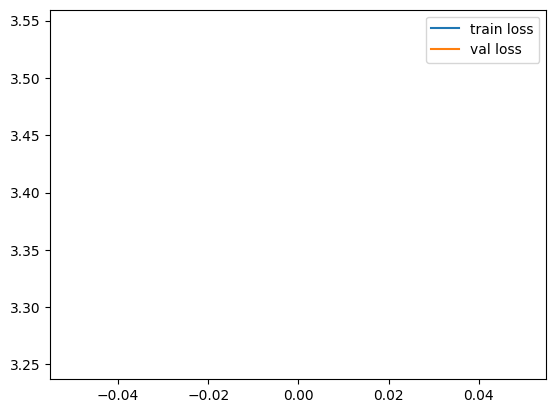

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

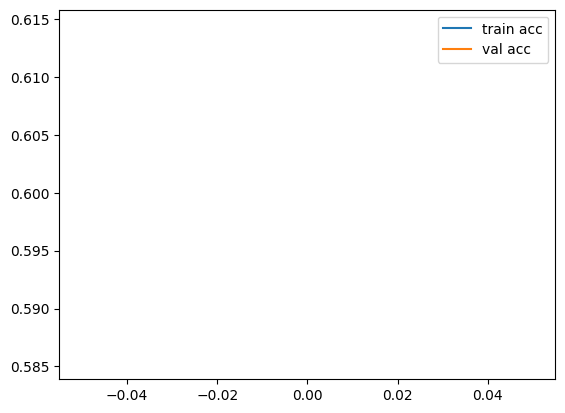

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#model.save('BC.h5')
from keras.models import load_model
#from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import img_to_array
# from tensorflow.keras.utils import img_to_array
# from keras_preprocessing.image import img_to_array
import cv2
# img = cv2.imread(img_dir)
# # from PIL import lo
# target_size=(224,224,3)

model1 = load_model('C:\projects\DEEP_CNN_CLASSIFIER1\BC.h5',compile=False)  
lab = training_set.class_indices
lab={k:v for v,k in lab.items()}
def output(location):
    img=cv2.imread(location)
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    return res

In [ ]:
img='artifacts\data_ingestion\test\ABBOTTS BABBLER\1.jpg'
pic=cv2.imread('artifacts\data_ingestion\test\ABBOTTS BABBLER\1.jpg')
#plt.imshow(pic)
#output(img)


TypeError: Image data of dtype <U49 cannot be converted to float

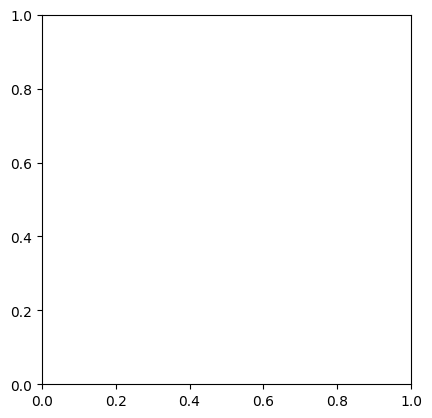

In [ ]:
plt.imshow('artifacts\data_ingestion\test\ABBOTTS BABBLER\1.jpg')

In [ ]:
import tensorflow as tf
from PIL import Image
model = tf.keras.models.load_model("C:\projects\DEEP_CNN_CLASSIFIER1\BC.h5") # loading the already saved model
#uploaded_file = st.file_uploader("Choose a file") # uploading the file to the streamlit server
# if uploaded_file is not None:
#     # To read file as bytes:

image = Image.open() # This will contain file in some unreadable format basically in bytes format
img1 = image.resize((224,224)) 
img_array = np.array(img1)
img_array = np.expand_dims(img_array, axis=0) # [batch_size, row, col, channel]
result = model.predict(img_array) # [[0.99, 0.01], [0.99, 0.01]]



OSError: [Errno 22] Invalid argument: 'artifacts\\data_ingestion\test\\ABBOTTS BABBLER\x01.jpg'

In [ ]:
import streamlit as st
from PIL import Image
from tensorflow.keras.utils import img_to_array
import numpy as np
from keras.models import load_model

model = load_model('C:\projects\DEEP_CNN_CLASSIFIER1\BC.h5',compile=False)
lab = {0: 'AFRICAN CROWNED CRANE', 1: 'AFRICAN FIREFINCH', 2: 'ALBATROSS', 3: 'ALEXANDRINE PARAKEET', 4: 'AMERICAN AVOCET', 5: 'AMERICAN BITTERN', 6: 'AMERICAN COOT', 7: 'AMERICAN GOLDFINCH', 8: 'AMERICAN KESTREL', 9: 'AMERICAN PIPIT', 10: 'AMERICAN REDSTART', 11: 'ANHINGA', 12: 'ANNAS HUMMINGBIRD', 13: 'ANTBIRD', 14: 'ARARIPE MANAKIN', 15: 'ASIAN CRESTED IBIS', 16: 'BALD EAGLE', 17: 'BALI STARLING', 18: 'BALTIMORE ORIOLE', 19: 'BANANAQUIT', 20: 'BANDED BROADBILL', 21: 'BAR-TAILED GODWIT', 22: 'BARN OWL', 23: 'BARN SWALLOW', 24: 'BARRED PUFFBIRD', 25: 'BAY-BREASTED WARBLER', 26: 'BEARDED BARBET', 27: 'BEARDED REEDLING', 28: 'BELTED KINGFISHER', 29: 'BIRD OF PARADISE', 30: 'BLACK & YELLOW bROADBILL', 31: 'BLACK FRANCOLIN', 32: 'BLACK SKIMMER', 33: 'BLACK SWAN', 34: 'BLACK TAIL CRAKE', 35: 'BLACK THROATED BUSHTIT', 36: 'BLACK THROATED WARBLER', 37: 'BLACK VULTURE', 38: 'BLACK-CAPPED CHICKADEE', 39: 'BLACK-NECKED GREBE', 40: 'BLACK-THROATED SPARROW', 41: 'BLACKBURNIAM WARBLER', 42: 'BLUE GROUSE', 43: 'BLUE HERON', 44: 'BOBOLINK', 45: 'BORNEAN BRISTLEHEAD', 46: 'BORNEAN LEAFBIRD', 47: 'BROWN NOODY', 48: 'BROWN THRASHER', 49: 'BULWERS PHEASANT', 50: 'CACTUS WREN', 51: 'CALIFORNIA CONDOR', 52: 'CALIFORNIA GULL', 53: 'CALIFORNIA QUAIL', 54: 'CANARY', 55: 'CAPE MAY WARBLER', 56: 'CAPUCHINBIRD', 57: 'CARMINE BEE-EATER', 58: 'CASPIAN TERN', 59: 'CASSOWARY', 60: 'CEDAR WAXWING', 61: 'CHARA DE COLLAR', 62: 'CHIPPING SPARROW', 63: 'CHUKAR PARTRIDGE', 64: 'CINNAMON TEAL', 65: 'COCK OF THE  ROCK', 66: 'COCKATOO', 67: 'COMMON FIRECREST', 68: 'COMMON GRACKLE', 69: 'COMMON HOUSE MARTIN', 70: 'COMMON LOON', 71: 'COMMON POORWILL', 72: 'COMMON STARLING', 73: 'COUCHS KINGBIRD', 74: 'CRESTED AUKLET', 75: 'CRESTED CARACARA', 76: 'CRESTED NUTHATCH', 77: 'CROW', 78: 'CROWNED PIGEON', 79: 'CUBAN TODY', 80: 'CURL CRESTED ARACURI', 81: 'D-ARNAUDS BARBET', 82: 'DARK EYED JUNCO', 83: 'DOUBLE BARRED FINCH', 84: 'DOWNY WOODPECKER', 85: 'EASTERN BLUEBIRD', 86: 'EASTERN MEADOWLARK', 87: 'EASTERN ROSELLA', 88: 'EASTERN TOWEE', 89: 'ELEGANT TROGON', 90: 'ELLIOTS  PHEASANT', 91: 'EMPEROR PENGUIN', 92: 'EMU', 93: 'ENGGANO MYNA', 94: 'EURASIAN GOLDEN ORIOLE', 95: 'EURASIAN MAGPIE', 96: 'EVENING GROSBEAK', 97: 'FIRE TAILLED MYZORNIS', 98: 'FLAME TANAGER', 99: 'FLAMINGO', 100: 'FRIGATE', 101: 'GAMBELS QUAIL', 102: 'GANG GANG COCKATOO', 103: 'GILA WOODPECKER', 104: 'GILDED FLICKER', 105: 'GLOSSY IBIS', 106: 'GO AWAY BIRD', 107: 'GOLD WING WARBLER', 108: 'GOLDEN CHEEKED WARBLER', 109: 'GOLDEN CHLOROPHONIA', 110: 'GOLDEN EAGLE', 111: 'GOLDEN PHEASANT', 112: 'GOLDEN PIPIT', 113: 'GOULDIAN FINCH', 114: 'GRAY CATBIRD', 115: 'GRAY PARTRIDGE', 116: 'GREAT POTOO', 117: 'GREATOR SAGE GROUSE', 118: 'GREEN JAY', 119: 'GREEN MAGPIE', 120: 'GREY PLOVER', 121: 'GUINEA TURACO', 122: 'GUINEAFOWL', 123: 'GYRFALCON', 124: 'HARPY EAGLE', 125: 'HAWAIIAN GOOSE', 126: 'HELMET VANGA', 127: 'HIMALAYAN MONAL', 128: 'HOATZIN', 129: 'HOODED MERGANSER', 130: 'HOOPOES', 131: 'HORNBILL', 132: 'HORNED GUAN', 133: 'HORNED SUNGEM', 134: 'HOUSE FINCH', 135: 'HOUSE SPARROW', 136: 'IMPERIAL SHAQ', 137: 'INCA TERN', 138: 'INDIAN BUSTARD', 139: 'INDIAN PITTA', 140: 'INDIGO BUNTING', 141: 'JABIRU', 142: 'JAVA SPARROW', 143: 'KAKAPO', 144: 'KILLDEAR', 145: 'KING VULTURE', 146: 'KIWI', 147: 'KOOKABURRA', 148: 'LARK BUNTING', 149: 'LEARS MACAW', 150: 'LILAC ROLLER', 151: 'LONG-EARED OWL', 152: 'MAGPIE GOOSE', 153: 'MALABAR HORNBILL', 154: 'MALACHITE KINGFISHER', 155: 'MALEO', 156: 'MALLARD DUCK', 157: 'MANDRIN DUCK', 158: 'MARABOU STORK', 159: 'MASKED BOOBY', 160: 'MASKED LAPWING', 161: 'MIKADO  PHEASANT', 162: 'MOURNING DOVE', 163: 'MYNA', 164: 'NICOBAR PIGEON', 165: 'NOISY FRIARBIRD', 166: 'NORTHERN BALD IBIS', 167: 'NORTHERN CARDINAL', 168: 'NORTHERN FLICKER', 169: 'NORTHERN GANNET', 170: 'NORTHERN GOSHAWK', 171: 'NORTHERN JACANA', 172: 'NORTHERN MOCKINGBIRD', 173: 'NORTHERN PARULA', 174: 'NORTHERN RED BISHOP', 175: 'NORTHERN SHOVELER', 176: 'OCELLATED TURKEY', 177: 'OKINAWA RAIL', 178: 'OSPREY', 179: 'OSTRICH', 180: 'OYSTER CATCHER', 181: 'PAINTED BUNTIG', 182: 'PALILA', 183: 'PARADISE TANAGER', 184: 'PARUS MAJOR', 185: 'PEACOCK', 186: 'PELICAN', 187: 'PEREGRINE FALCON', 188: 'PHILIPPINE EAGLE', 189: 'PINK ROBIN', 190: 'PUFFIN', 191: 'PURPLE FINCH', 192: 'PURPLE GALLINULE', 193: 'PURPLE MARTIN', 194: 'PURPLE SWAMPHEN', 195: 'QUETZAL', 196: 'RAINBOW LORIKEET', 197: 'RAZORBILL', 198: 'RED BEARDED BEE EATER', 199: 'RED BELLIED PITTA', 200: 'RED BROWED FINCH', 201: 'RED FACED CORMORANT', 202: 'RED FACED WARBLER', 203: 'RED HEADED DUCK', 204: 'RED HEADED WOODPECKER', 205: 'RED HONEY CREEPER', 206: 'RED TAILED THRUSH', 207: 'RED WINGED BLACKBIRD', 208: 'RED WISKERED BULBUL', 209: 'REGENT BOWERBIRD', 210: 'RING-NECKED PHEASANT', 211: 'ROADRUNNER', 212: 'ROBIN', 213: 'ROCK DOVE', 214: 'ROSY FACED LOVEBIRD', 215: 'ROUGH LEG BUZZARD', 216: 'ROYAL FLYCATCHER', 217: 'RUBY THROATED HUMMINGBIRD', 218: 'RUFOUS KINGFISHER', 219: 'RUFUOS MOTMOT', 220: 'SAMATRAN THRUSH', 221: 'SAND MARTIN', 222: 'SCARLET IBIS', 223: 'SCARLET MACAW', 224: 'SHOEBILL', 225: 'SHORT BILLED DOWITCHER', 226: 'SMITHS LONGSPUR', 227: 'SNOWY EGRET', 228: 'SNOWY OWL', 229: 'SORA', 230: 'SPANGLED COTINGA', 231: 'SPLENDID WREN', 232: 'SPOON BILED SANDPIPER', 233: 'SPOONBILL', 234: 'SRI LANKA BLUE MAGPIE', 235: 'STEAMER DUCK', 236: 'STORK BILLED KINGFISHER', 237: 'STRAWBERRY FINCH', 238: 'STRIPPED SWALLOW', 239: 'SUPERB STARLING', 240: 'SWINHOES PHEASANT', 241: 'TAIWAN MAGPIE', 242: 'TAKAHE', 243: 'TASMANIAN HEN', 244: 'TEAL DUCK', 245: 'TIT MOUSE', 246: 'TOUCHAN', 247: 'TOWNSENDS WARBLER', 248: 'TREE SWALLOW', 249: 'TRUMPTER SWAN', 250: 'TURKEY VULTURE', 251: 'TURQUOISE MOTMOT', 252: 'UMBRELLA BIRD', 253: 'VARIED THRUSH', 254: 'VENEZUELIAN TROUPIAL', 255: 'VERMILION FLYCATHER', 256: 'VICTORIA CROWNED PIGEON', 257: 'VIOLET GREEN SWALLOW', 258: 'VULTURINE GUINEAFOWL', 259: 'WATTLED CURASSOW', 260: 'WHIMBREL', 261: 'WHITE CHEEKED TURACO', 262: 'WHITE NECKED RAVEN', 263: 'WHITE TAILED TROPIC', 264: 'WILD TURKEY', 265: 'WILSONS BIRD OF PARADISE', 266: 'WOOD DUCK', 267: 'YELLOW BELLIED FLOWERPECKER', 268: 'YELLOW CACIQUE', 269: 'YELLOW HEADED BLACKBIRD'}

def processed_img(img_path):
    img=tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    print(res)
    return res

def run():
    img1 = Image.open('C:\projects\DEEP_CNN_CLASSIFIER1\download.jpeg')
    img1 = img1.resize((350,350))
    st.image(img1,use_column_width=False)
    st.title("Birds Species Classification")
    st.markdown('''<h4 style='text-align: left; color: #d73b5c;'>* Data is based "270 Bird Species also see 70 Sports Dataset"</h4>''',
                unsafe_allow_html=True)

    img_file = st.file_uploader("Choose an Image of Bird", type=["jpg", "png"])
    if img_file is not None:
        st.image(img_file,use_column_width=False)
        save_image_path = './upload_images/'+img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())

        if st.button("Predict"):
            result = processed_img(save_image_path)
            st.success("Predicted Bird is: "+result)
run()

2023-04-23 13:53:31.505 
  command:

    streamlit run c:\projects\DEEP_CNN_CLASSIFIER1\env\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
import streamlit as st
from PIL import Image
import tensorflow as tf
import numpy as np
def run():
    """

    #  IMAGE CLASSIFICATION PROJECT 

    """
    model = tf.keras.models.load_model("C:\projects\DEEP_CNN_CLASSIFIER1\BC.h5") # loading the already saved model
    uploaded_file = st.file_uploader("Choose a file") # uploading the file to the streamlit server
    if uploaded_file is not None:
        # To read file as bytes:

        image = Image.open(uploaded_file) # This will contain file in some unreadable format basically in bytes format
        img = image.resize((224,224)) 
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0) # [batch_size, row, col, channel]
        result = model.predict(img_array) # [[0.99, 0.01], [0.99, 0.01]]

        argmax_index = np.argmax(result, axis=1) # [0, 0]
        if argmax_index[0] == 0:
            st.image(image, caption="predicted: cat")
        else:
            st.image(image, caption='predicted: dog')

run()
            

In [ ]:
import torch
from torchvision import models
import cv2
def is_bird(image_path):
    # Load the object detection model
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    
    # Load the image and convert it to a tensor
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor = torch.from_numpy(image).permute(2,0,1).unsqueeze(0).float()
    
    # Run the image through the object detection model
    with torch.no_grad():
        output = model(tensor)
    
    # Check if any detected object is not a bird
    for i in range(output[0]['labels'].shape[0]):
        label = output[0]['labels'][i].item()
        if label != 16: # 16 is the label index for birds in the COCO dataset
            return False
    
    return True


In [ ]:
is_bird("C:\projects\DEEP_CNN_CLASSIFIER1\artifacts\data_ingestion\train\ABBOTTS BABBLER\001.jpg")

c:\projects\DEEP_CNN_CLASSIFIER1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\DEEP_CNN_CLASSIFIER1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
is_bird("C:\projects\DEEP_CNN_CLASSIFIER1\photo-1606567595334-d39972c85dbe.jpeg")

False

In [ ]:
import cv2

# Load the pre-trained Haar cascade classifier for bird detection
bird_cascade = cv2.CascadeClassifier('bird_cascade.xml')

# Define a function to check if an image is a bird image or not
def is_bird_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect bird objects in the image using the bird cascade classifier
    birds = bird_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # If there are no bird objects detected, return False
    if len(birds) == 0:
        return False

    # Otherwise, return True
    return True


In [ ]:
image_path=r"C:\projects\DEEP_CNN_CLASSIFIER1\artifacts\data_ingestion\train\YELLOW BELLIED FLOWERPECKER\154.jpg"
is_bird_image(image_path=image_path)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [ ]:
pip uninstall opencv-python

^C
Note: you may need to restart the kernel to use updated packages.
